### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1ygSQdg0_3KzCXK0mWufNykWjfoYjWqKH/Progetto AN2DL


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 5

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [4]:
# Import other libraries
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

### Load data

In [5]:
# Load data
data = np.load('training_dataset/training_data.npy', allow_pickle=True)
periods = np.load('training_dataset/valid_periods.npy', allow_pickle=True)
categories = np.load('training_dataset/categories.npy', allow_pickle=True)

# Change data type
data = data.astype(np.float32)
periods = periods.astype(np.int32)

### Data Analysis

In [6]:
# Print data shape
print(f"Data shape: {data.shape}")
print(f"Periods shape: {periods.shape}")
print(f"Categories shape: {categories.shape}")

# Print data info
print(f"Max period: {np.diff(periods).max()}")
print(f"Min period: {np.diff(periods).min()}")
print(f"Mean period: {np.diff(periods).mean()}")

Data shape: (48000, 2776)
Periods shape: (48000, 2)
Categories shape: (48000,)
Max period: 2776
Min period: 24
Mean period: 198.30022916666667


In [7]:
# Find all possible labels
labels = []
for label in categories:
  if label not in labels:
    labels.append(label)
labels = sorted(labels)
print(f"Possible labels: {labels}")

Possible labels: ['A', 'B', 'C', 'D', 'E', 'F']


In [8]:
# Compute the number of elements for each label
count = 0
num_elem = {}
for label in labels:
  for category in categories:
    if label == category:
      count = count + 1
  num_elem.update({label: count})
  count = 0
print(f"Number of elements per label: {num_elem}")

Number of elements per label: {'A': 5728, 'B': 10987, 'C': 10017, 'D': 10016, 'E': 10975, 'F': 277}


In [16]:
# Returns True if there are missing values in data
def hasMissingValues(data, period):
  for i in range(period[0], period[1]):
    if np.isnan(data[i]):
      return True
  return False

# Compute the number of sequences having missing values
count = 0
for i in range(data.shape[0]):
  if hasMissingValues(data[i], periods[i]):
    count = count + 1
print(f"There are {count} sequences with missing values")
print(f"Percentage of sequence with missing values: {count/data.shape[0]}")

# Compute the number of missing values
nan_count = np.isnan(data).sum()
print(f"There are {nan_count} missing values")

There are 0 sequences with missing values
Percentage of sequence with missing values: 0.0
There are 0 missing values


In [10]:
# Compute the number of sequences with lenght smaller or equal than N
def numberOfSequencesSmallerOrEqualThanN(periods, N):
  count = 0
  diff = np.diff(periods)
  for value in diff:
    if value <= N:
      count = count + 1
  return count

print(f"Number of sequences smaller or equal than 25: {numberOfSequencesSmallerOrEqualThanN(periods, 25)}")
print(f"Number of sequences smaller or equal than 30: {numberOfSequencesSmallerOrEqualThanN(periods, 30)}")
print(f"Number of sequences smaller or equal than 35: {numberOfSequencesSmallerOrEqualThanN(periods, 35)}")
print(f"Number of sequences smaller or equal than 40: {numberOfSequencesSmallerOrEqualThanN(periods, 40)}")
print(f"Number of sequences smaller or equal than 45: {numberOfSequencesSmallerOrEqualThanN(periods, 45)}")
print(f"Number of sequences smaller or equal than 50: {numberOfSequencesSmallerOrEqualThanN(periods, 50)}")

Number of sequences smaller or equal than 25: 5
Number of sequences smaller or equal than 30: 11
Number of sequences smaller or equal than 35: 15
Number of sequences smaller or equal than 40: 18
Number of sequences smaller or equal than 45: 308
Number of sequences smaller or equal than 50: 2504


### Manage constant signals

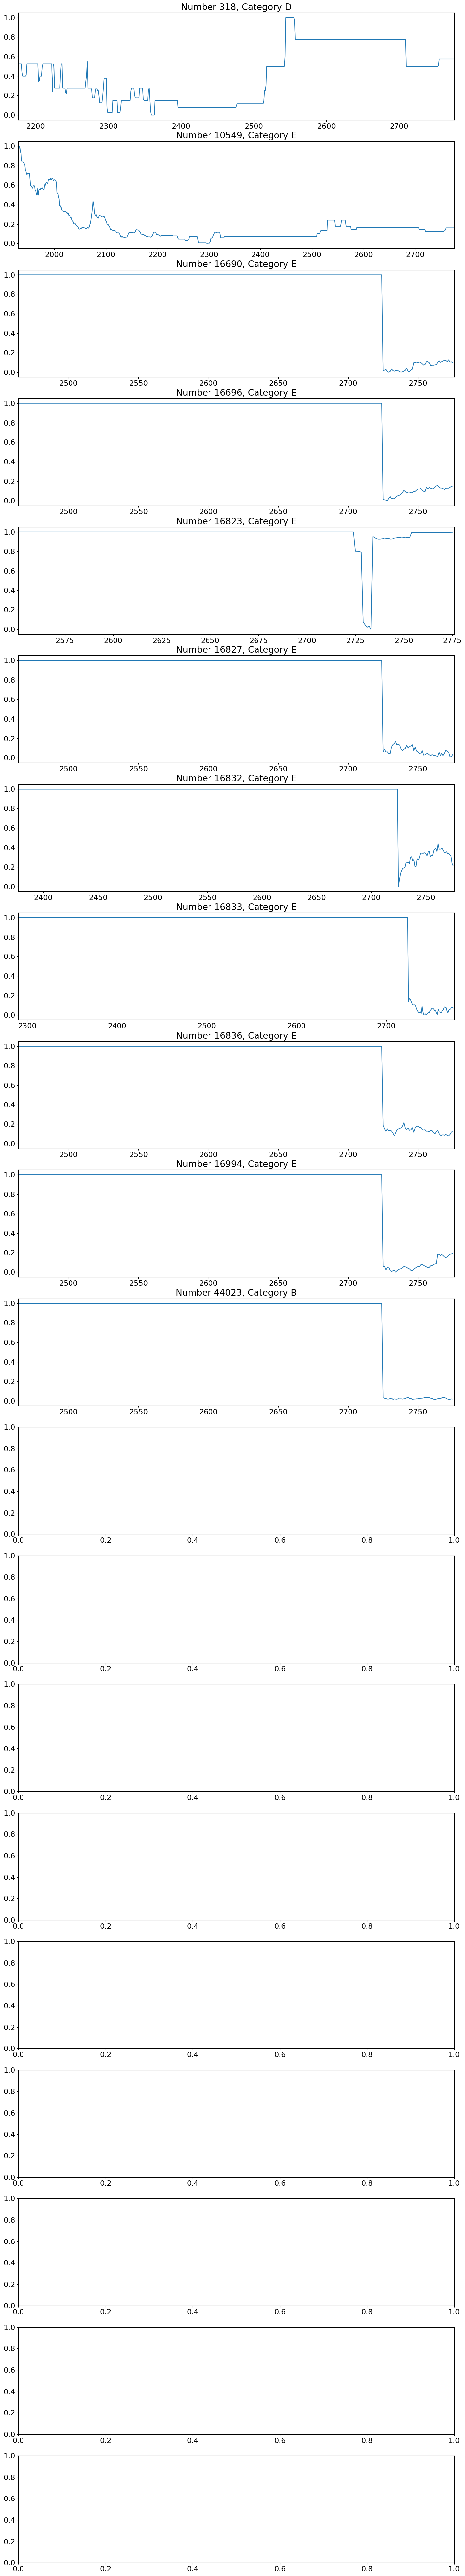

In [ ]:
def find_constant_signals(data, periods, categories, cols):
  figs, axs = plt.subplots(cols, 1, figsize=(17,100))
  threshold = 150
  idx = -1
  for i in range(cols):
    for k in range(idx + 1, data.shape[0]):
      const_cont = 0
      const = data[k,0]
      threshold_reached = False
      for j in range(1, data[k].shape[0]):
        if data[k,j] == const and const != 0.0:
          const_cont = const_cont + 1
        else:
          const = data[k,j]
          const_cont = 0
        if(const_cont > threshold):
            idx = k
            threshold_reached = True
            break
      if(threshold_reached):
        break
    if(threshold_reached):
      axs[i].plot(data[k])
      axs[i].set_title("Number " +str(k)+ ", Category " +str(categories[k]))
      axs[i].set_xlim(periods[k])
    else:
      break

  plt.show()

find_constant_signals(data, periods, categories, 20)

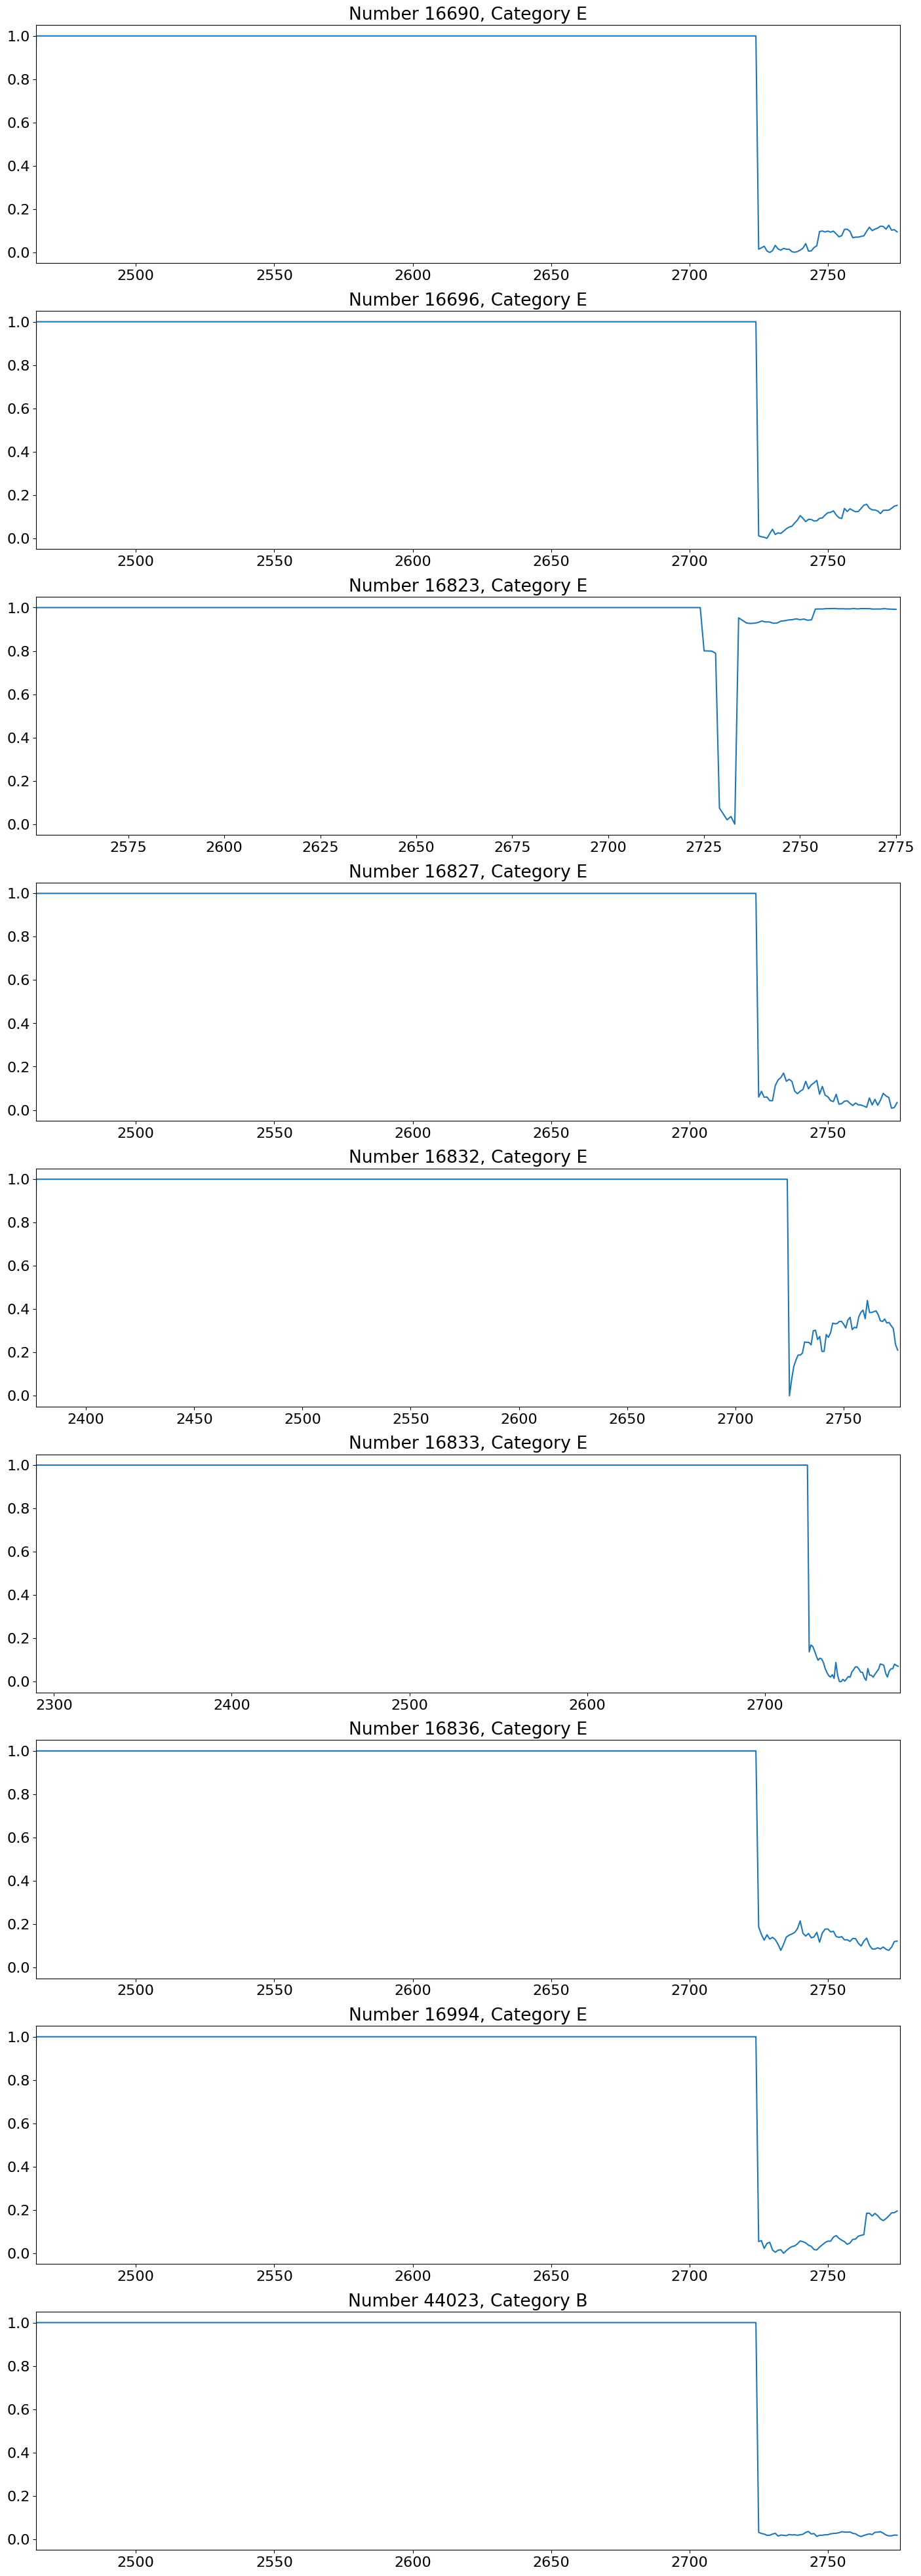

In [ ]:
const_indices =  [16690, 16696, 16823, 16827, 16832, 16833, 16836, 16994, 44023]

def inspect_data(data, periods, categories, cols):
  figs, axs = plt.subplots(len(cols), 1, figsize=(17,50))
  for i, col in enumerate(cols):
        axs[i].plot(data[col])
        axs[i].set_title("Number " +str(col)+ ", Category " +str(categories[col]))
        axs[i].set_xlim(periods[col])
  plt.show()

# Check Outliers
inspect_data(data, periods, categories, const_indices)

In [ ]:
# Remove Outliers
new_data = []
new_periods = []
new_categories = []
for i in range(data.shape[0]):
  if(i in const_indices):
    continue
  else:
    new_data.append(data[i])
    new_periods.append(periods[i])
    new_categories.append(categories[i])
new_data = np.array(new_data)
new_periods = np.array(new_periods)
new_categories = np.array(new_categories)

print(data.shape)
print(new_data.shape)

(48000, 2776)
(47991, 2776)


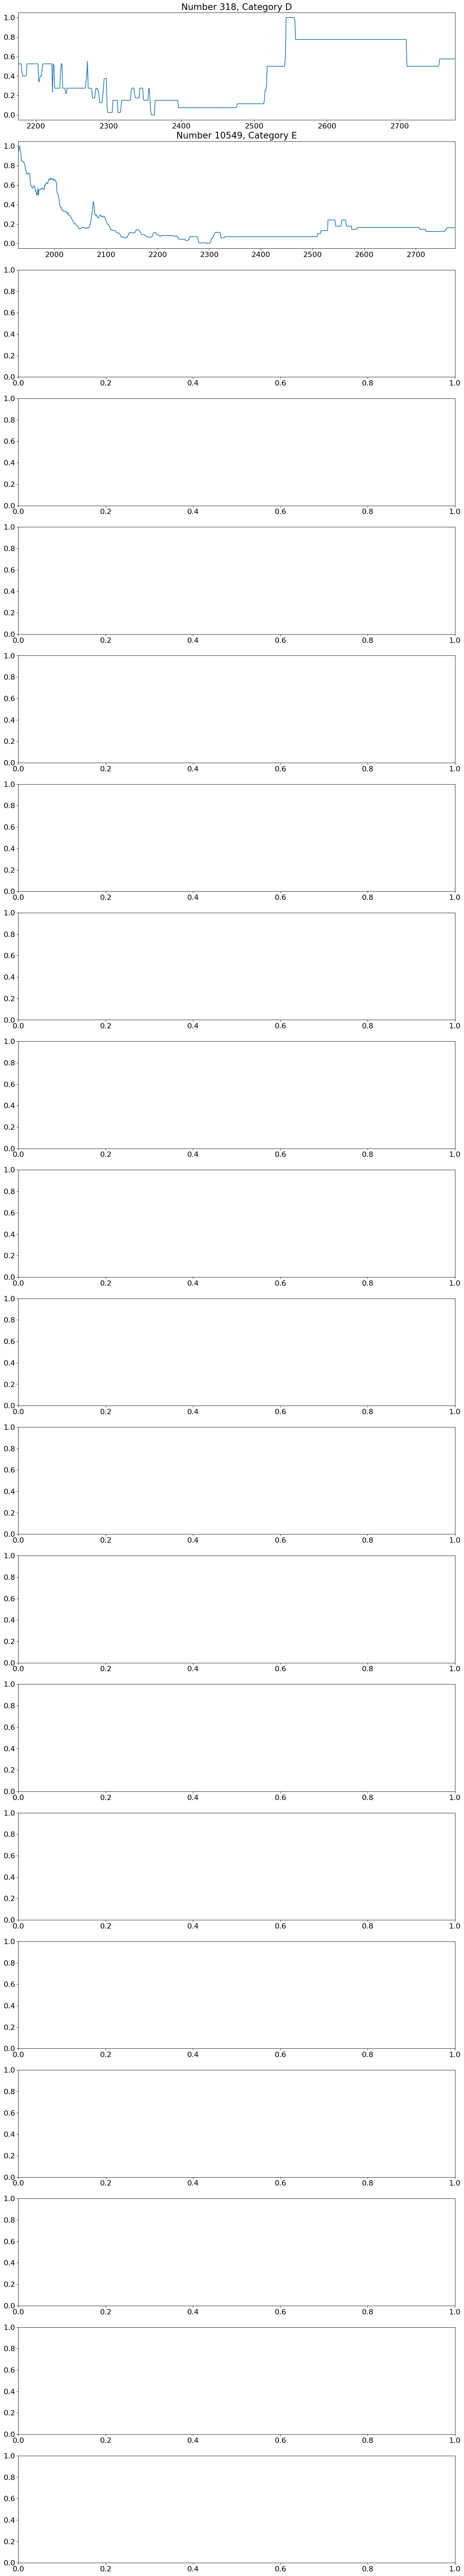

In [ ]:
#Check if all outliers have been removed
find_constant_signals(new_data, new_periods, new_categories, 20)

In [ ]:
noconst_data = new_data
noconst_periods = new_periods
noconst_categories = new_categories

noconst_data.shape, noconst_periods.shape, noconst_categories.shape

((47991, 2776), (47991, 2), (47991,))

### Shuffle data

In [ ]:
# Shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
periods = periods[indices]
categories = categories[indices]

# Shuffle data w/o constant signals
indices = np.arange(noconst_data.shape[0])
np.random.shuffle(indices)
noconst_data = noconst_data[indices]
noconst_periods = noconst_periods[indices]
noconst_categories = noconst_categories[indices]

### Inspect categories

In [ ]:
# Plot a certain number of data sequences related to a specific category
def inspect_category(data, periods, categories, category, rows, cols):
  figs, axs = plt.subplots(rows, cols, figsize=(cols*7,rows*5))
  idx = -1
  for i in range(rows):
    for j in range(cols):
      for k in range(idx + 1, categories.shape[0]):
        if categories[k] == category:
          idx = k
          break;
      axs[i][j].plot(data[idx])
      axs[i][j].set_title("Number " +str(idx)+ ", Category " +str(categories[idx]))
      axs[i][j].set_xlim(periods[idx])
  plt.show()

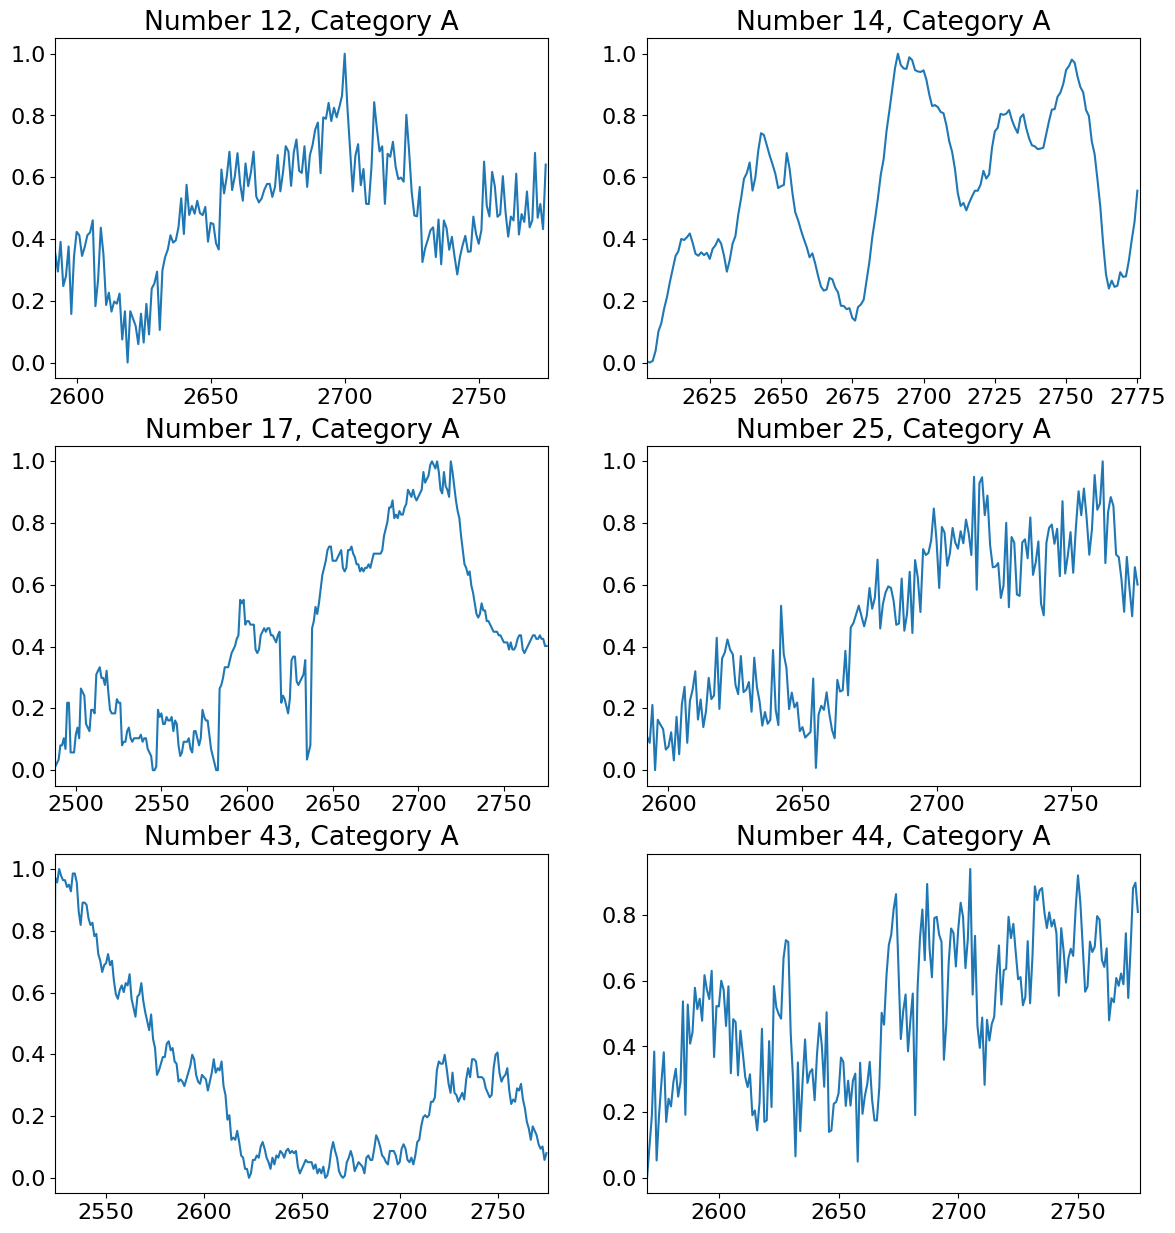

In [ ]:
inspect_category(data, periods, categories, 'A', 3, 2)

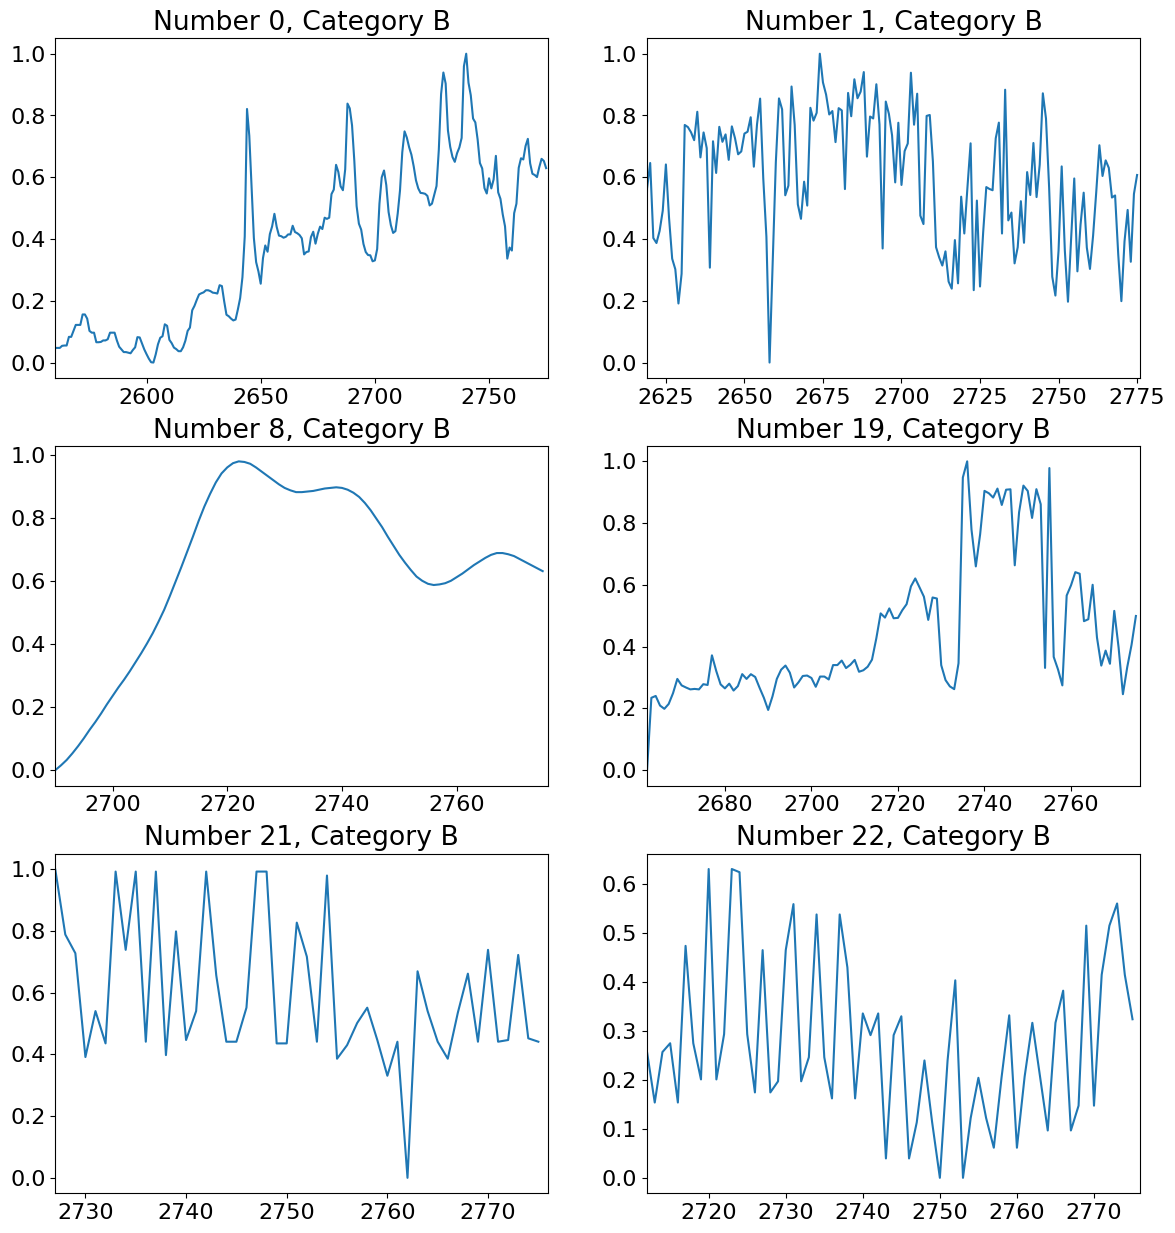

In [ ]:
inspect_category(data, periods, categories, 'B', 3, 2)

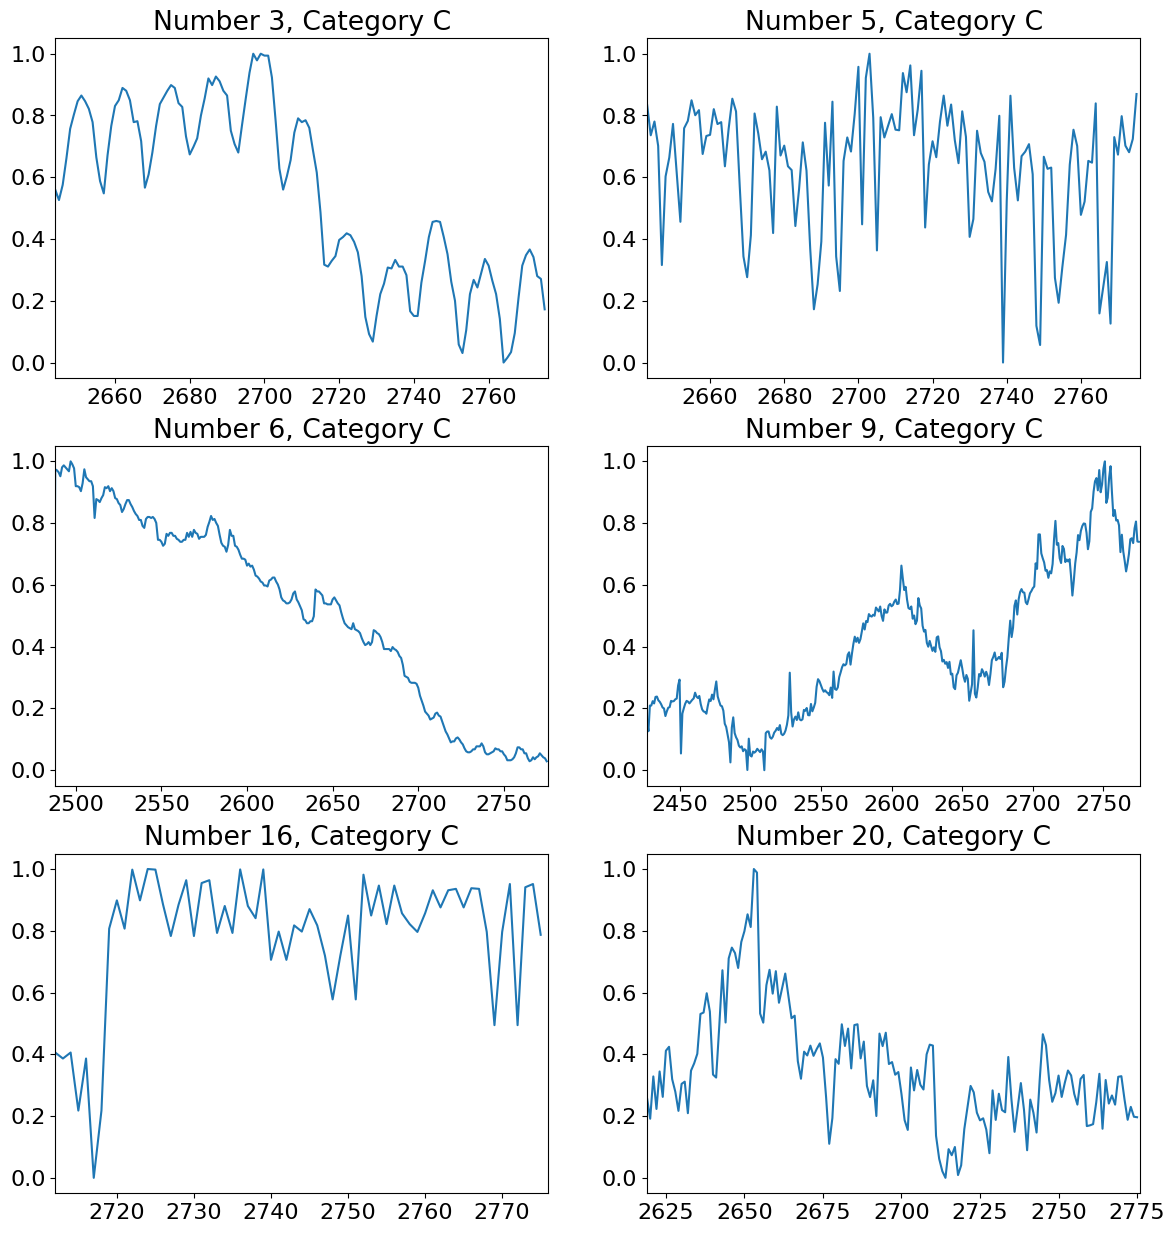

In [ ]:
inspect_category(data, periods, categories, 'C', 3, 2)

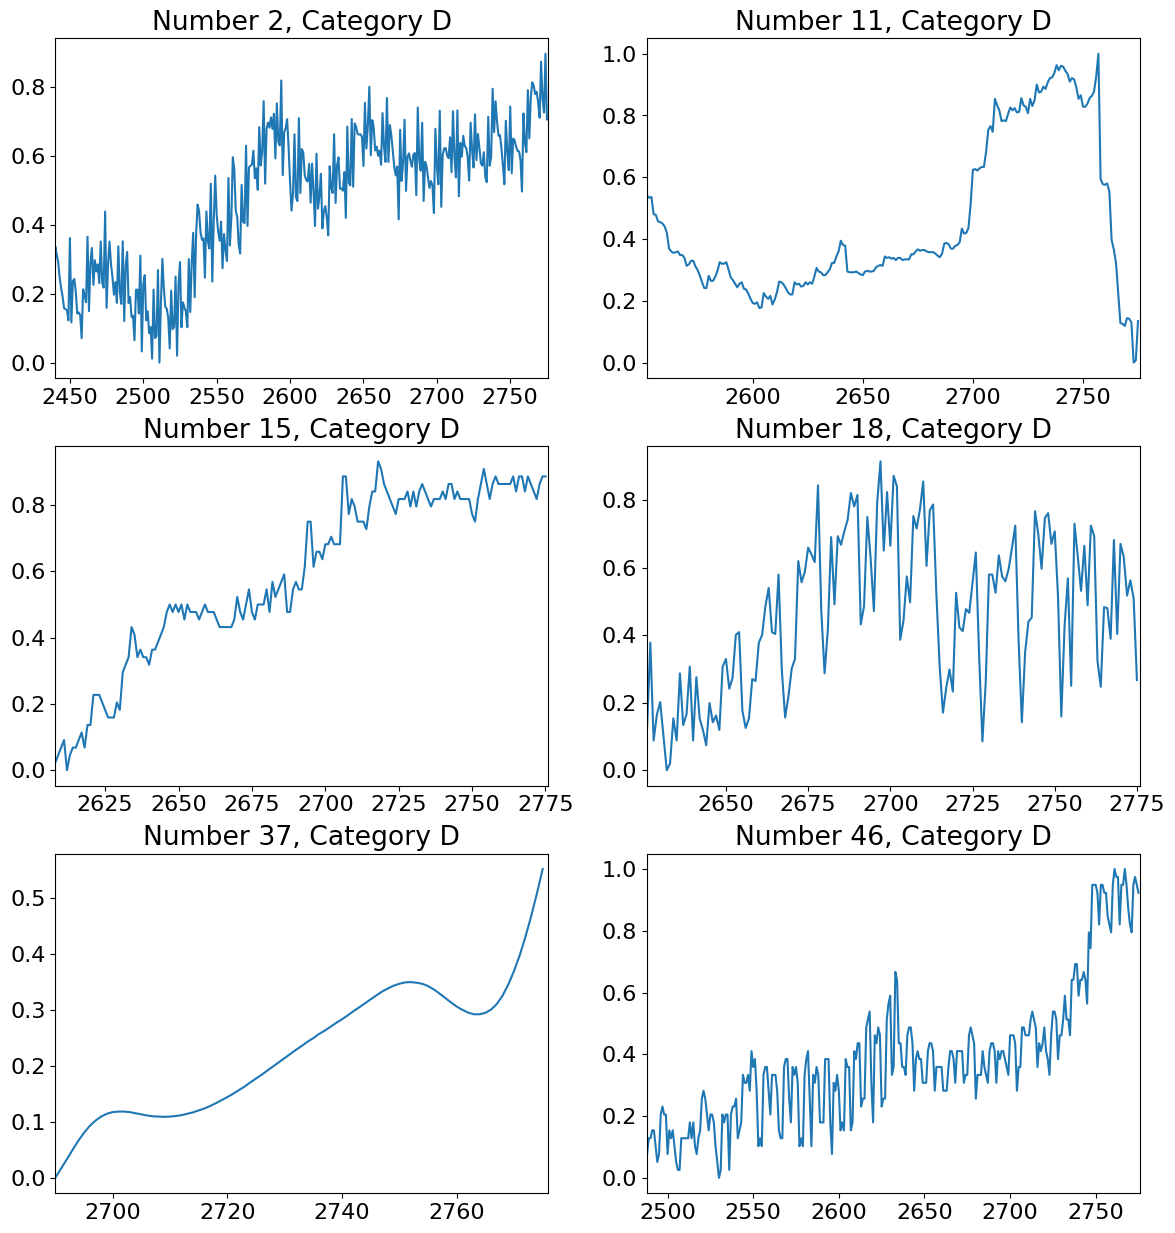

In [ ]:
inspect_category(data, periods, categories, 'D', 3, 2)

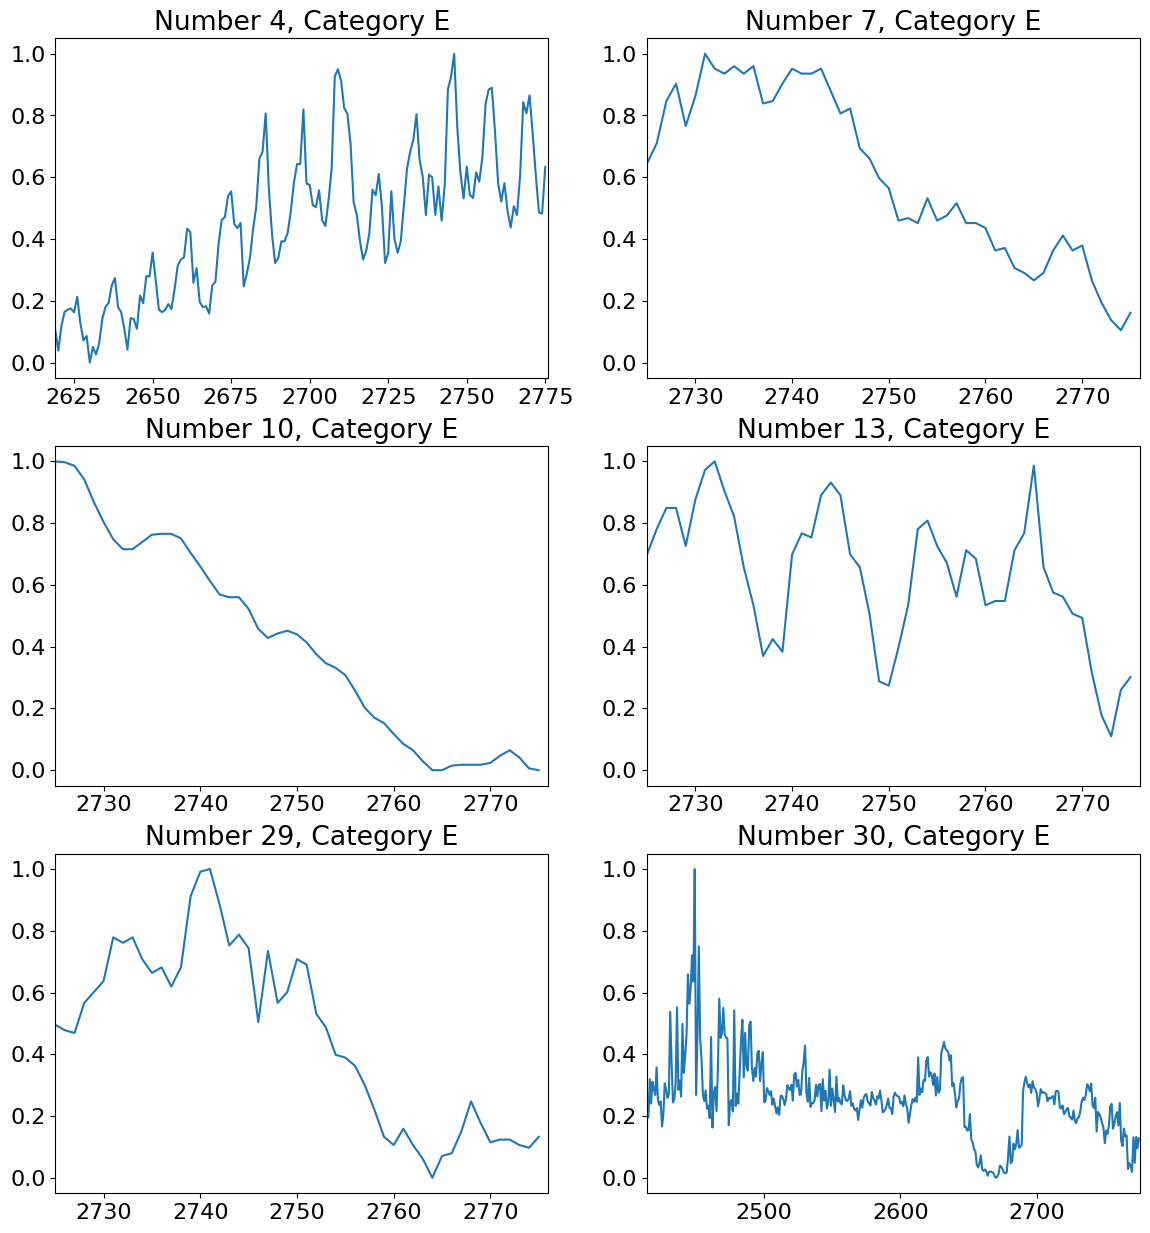

In [ ]:
inspect_category(data, periods, categories, 'E', 3, 2)

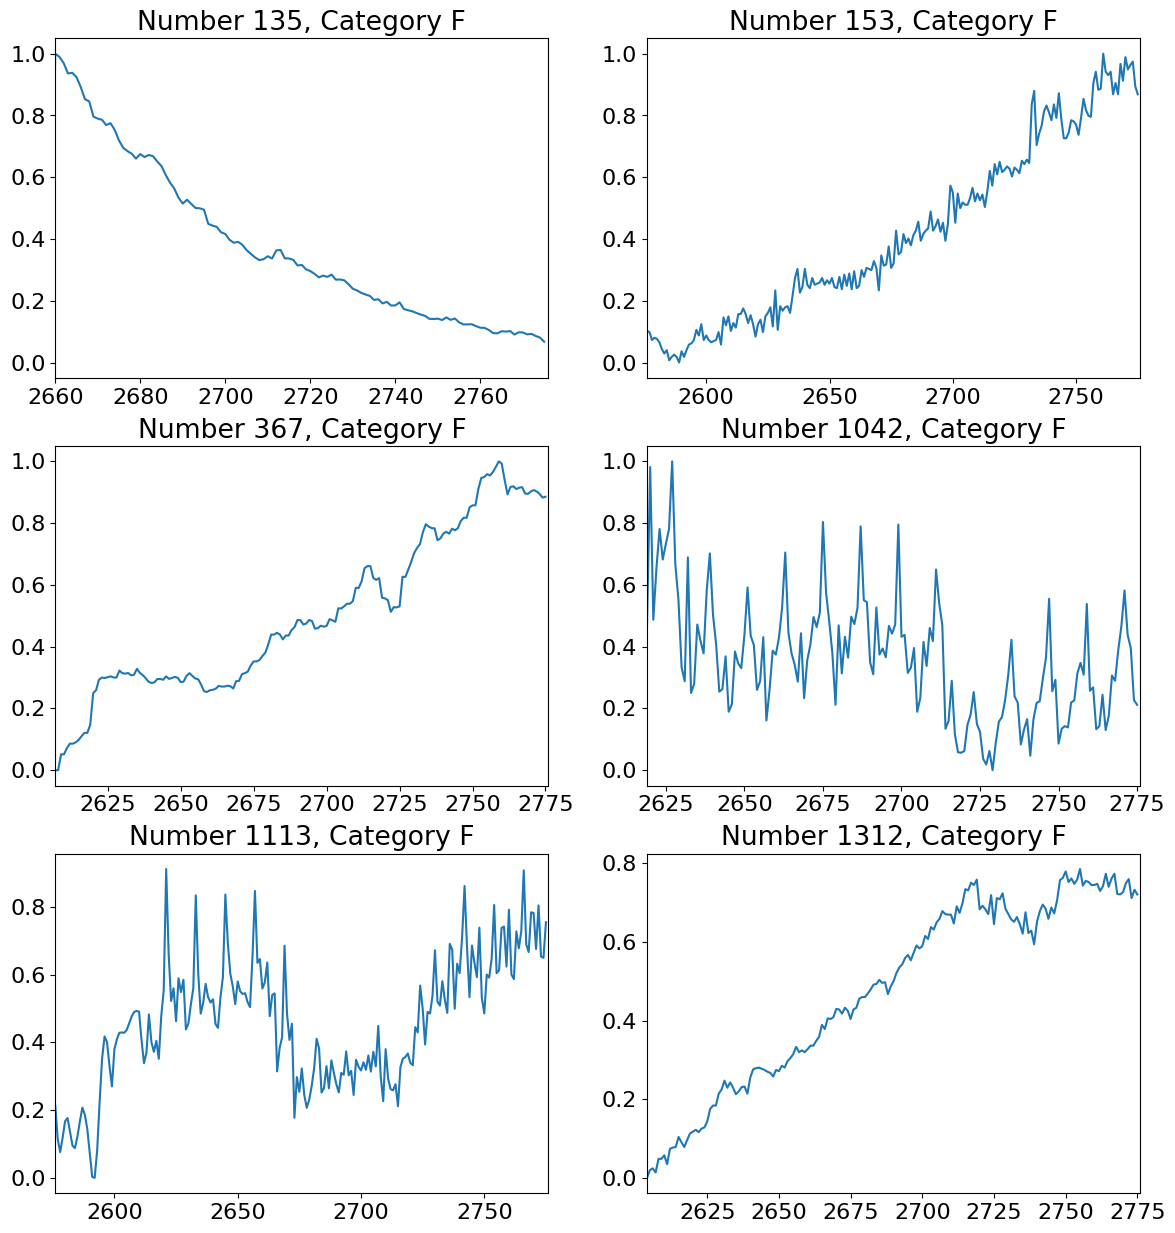

In [ ]:
inspect_category(data, periods, categories, 'F', 3, 2)

### Auxiliary functions

In [ ]:
# Generate a new dataset w/o the sequences smaller than N
def generateNewDataset(dataset, periods, categories, N):
  diff = np.diff(periods)
  number_short_sequences = numberOfSequencesSmallerOrEqualThanN(periods, N)
  new_dataset = np.zeros(shape=(dataset.shape[0] - number_short_sequences, dataset.shape[1]), dtype='float32')
  new_periods = np.zeros(shape=(dataset.shape[0] - number_short_sequences, periods.shape[1]),dtype='int32')
  new_categories = np.chararray((dataset.shape[0] - number_short_sequences,), unicode=True)

  shift = 0
  for i in range(dataset.shape[0]):
    if diff[i] > N:
      new_dataset[shift] = dataset[i]
      new_periods[shift] = periods[i]
      new_categories[shift] = categories[i][0]
      shift = shift + 1

  return new_dataset, new_periods, new_categories

In [ ]:
# Split data between training and validation
def splitData(data, periods, categories, labels, num_elem, split_percentage=0.9):
  # Compute the number of elements in the training set and in the validation set for each label
  train_dim = {}
  val_dim = {}
  for label in labels:
    train_dim.update({label: round(num_elem[label] * split_percentage)})
    val_dim.update({label: num_elem[label] - train_dim[label]})

  print(f"Number of elements per label: {num_elem}")
  print(f"Number of elements per label (Training set): {train_dim}")
  print(f"Number of elements per label (Validation set): {val_dim}")

  counter = {}        # Dictionary containing the number of elements inserted in the training set for each label
  val_elem = 0        # Number of elements in the validation set
  training_elem = 0   # Number of elements in the training set

  # Init counter, val_elem, training_elem
  for label in labels:
    counter.update({label:0})
    val_elem = val_elem + val_dim[label]
    training_elem = training_elem + train_dim[label]

  print(f"Number of training elem: {training_elem}")
  print(f"Number of validation elem: {val_elem}")

  # Init arrays for training and validation
  data_train = np.zeros(shape=(training_elem, data.shape[1]),dtype='float32')
  data_val = np.zeros(shape=(val_elem, data.shape[1]),dtype='float32')
  periods_train = np.zeros(shape=(training_elem, periods.shape[1]),dtype='int32')
  periods_val = np.zeros(shape=(val_elem, periods.shape[1]),dtype='int32')
  category_train = np.chararray((training_elem,), unicode=True)
  category_val = np.chararray((val_elem,), unicode=True)

  # Split data between training and validation
  train_shift = 0
  val_shift = 0
  for i in range(data.shape[0]):
    if counter[categories[i]] < train_dim[categories[i]]:
      counter[categories[i]] = counter[categories[i]] + 1
      data_train[train_shift] = data[i]
      periods_train[train_shift] = periods[i]
      category_train[train_shift] = categories[i]
      train_shift = train_shift + 1
    else:
      data_val[val_shift] = data[i]
      periods_val[val_shift] = periods[i]
      category_val[val_shift] = categories[i]
      val_shift = val_shift + 1

  return data_train, periods_train, category_train, data_val, periods_val, category_val

### Generation of modified datasets

In [ ]:
%rm -rf training_dataset/split_dataset
%mkdir training_dataset/split_dataset

# Compute the number of elements for each label
count = 0
num_elem = {}
for label in labels:
  for category in categories:
    if label == category[0]:
      count = count + 1
  num_elem.update({label: count})
  count = 0

# Split data in training set and validation set
data_train, periods_train, category_train, data_val, periods_val, category_val = splitData(
    data, periods, categories, labels, num_elem
)

np.save('training_dataset/split_dataset/data_train', data_train)
np.save('training_dataset/split_dataset/periods_train', periods_train)
np.save('training_dataset/split_dataset/category_train', category_train)
np.save('training_dataset/split_dataset/data_val', data_val)
np.save('training_dataset/split_dataset/periods_val', periods_val)
np.save('training_dataset/split_dataset/category_val', category_val)

Number of elements per label: {'A': 5728, 'B': 10987, 'C': 10017, 'D': 10016, 'E': 10975, 'F': 277}
Number of elements per label (Training set): {'A': 5155, 'B': 9888, 'C': 9015, 'D': 9014, 'E': 9878, 'F': 249}
Number of elements per label (Validation set): {'A': 573, 'B': 1099, 'C': 1002, 'D': 1002, 'E': 1097, 'F': 28}
Number of training elem: 43199
Number of validation elem: 4801


In [ ]:
%rm -rf training_dataset/25
%mkdir training_dataset/25

# Generate new dataset with only sequences greater than 25 in length
new_dataset, new_periods, new_categories = generateNewDataset(data, periods, categories, 25)

# Compute the number of elements for each label
count = 0
num_elem = {}
for label in labels:
  for category in new_categories:
    if label == category[0]:
      count = count + 1
  num_elem.update({label: count})
  count = 0

# Split data in training set and validation set
data_train, periods_train, category_train, data_val, periods_val, category_val = splitData(
    new_dataset, new_periods, new_categories, labels, num_elem
)

np.save('training_dataset/25/data_train', data_train)
np.save('training_dataset/25/periods_train', periods_train)
np.save('training_dataset/25/category_train', category_train)
np.save('training_dataset/25/data_val', data_val)
np.save('training_dataset/25/periods_val', periods_val)
np.save('training_dataset/25/category_val', category_val)

Number of elements per label: {'A': 5728, 'B': 10987, 'C': 10017, 'D': 10016, 'E': 10975, 'F': 272}
Number of elements per label (Training set): {'A': 5155, 'B': 9888, 'C': 9015, 'D': 9014, 'E': 9878, 'F': 245}
Number of elements per label (Validation set): {'A': 573, 'B': 1099, 'C': 1002, 'D': 1002, 'E': 1097, 'F': 27}
Number of training elem: 43195
Number of validation elem: 4800


In [ ]:
%rm -rf training_dataset/30
%mkdir training_dataset/30

# Generate new dataset with only sequences greater than 30 in length
new_dataset, new_periods, new_categories = generateNewDataset(data, periods, categories, 30)

# Compute the number of elements for each label
count = 0
num_elem = {}
for label in labels:
  for category in new_categories:
    if label == category[0]:
      count = count + 1
  num_elem.update({label: count})
  count = 0

# Split data in training set and validation set
data_train, periods_train, category_train, data_val, periods_val, category_val = splitData(
    new_dataset, new_periods, new_categories, labels, num_elem
)

np.save('training_dataset/30/data_train', data_train)
np.save('training_dataset/30/periods_train', periods_train)
np.save('training_dataset/30/category_train', category_train)
np.save('training_dataset/30/data_val', data_val)
np.save('training_dataset/30/periods_val', periods_val)
np.save('training_dataset/30/category_val', category_val)

Number of elements per label: {'A': 5728, 'B': 10987, 'C': 10017, 'D': 10016, 'E': 10975, 'F': 266}
Number of elements per label (Training set): {'A': 5155, 'B': 9888, 'C': 9015, 'D': 9014, 'E': 9878, 'F': 239}
Number of elements per label (Validation set): {'A': 573, 'B': 1099, 'C': 1002, 'D': 1002, 'E': 1097, 'F': 27}
Number of training elem: 43189
Number of validation elem: 4800


In [ ]:
%rm -rf training_dataset/35
%mkdir training_dataset/35

# Generate new dataset with only sequences greater than 35 in length
new_dataset, new_periods, new_categories = generateNewDataset(data, periods, categories, 35)

# Compute the number of elements for each label
count = 0
num_elem = {}
for label in labels:
  for category in new_categories:
    if label == category[0]:
      count = count + 1
  num_elem.update({label: count})
  count = 0

# Split data in training set and validation set
data_train, periods_train, category_train, data_val, periods_val, category_val = splitData(
    new_dataset, new_periods, new_categories, labels, num_elem
)

np.save('training_dataset/35/data_train', data_train)
np.save('training_dataset/35/periods_train', periods_train)
np.save('training_dataset/35/category_train', category_train)
np.save('training_dataset/35/data_val', data_val)
np.save('training_dataset/35/periods_val', periods_val)
np.save('training_dataset/35/category_val', category_val)

Number of elements per label: {'A': 5728, 'B': 10987, 'C': 10017, 'D': 10016, 'E': 10975, 'F': 262}
Number of elements per label (Training set): {'A': 5155, 'B': 9888, 'C': 9015, 'D': 9014, 'E': 9878, 'F': 236}
Number of elements per label (Validation set): {'A': 573, 'B': 1099, 'C': 1002, 'D': 1002, 'E': 1097, 'F': 26}
Number of training elem: 43186
Number of validation elem: 4799


In [ ]:
%rm -rf training_dataset/50
%mkdir training_dataset/50

# Generate new dataset with only sequences greater than 50 in length
new_dataset, new_periods, new_categories = generateNewDataset(data, periods, categories, 50)

# Compute the number of elements for each label
count = 0
num_elem = {}
for label in labels:
  for category in new_categories:
    if label == category[0]:
      count = count + 1
  num_elem.update({label: count})
  count = 0

# Split data in training set and validation set
data_train, periods_train, category_train, data_val, periods_val, category_val = splitData(
    new_dataset, new_periods, new_categories, labels, num_elem
)

np.save('training_dataset/50/data_train', data_train)
np.save('training_dataset/50/periods_train', periods_train)
np.save('training_dataset/50/category_train', category_train)
np.save('training_dataset/50/data_val', data_val)
np.save('training_dataset/50/periods_val', periods_val)
np.save('training_dataset/50/category_val', category_val)

Number of elements per label: {'A': 5727, 'B': 9251, 'C': 9411, 'D': 9936, 'E': 10938, 'F': 233}
Number of elements per label (Training set): {'A': 5154, 'B': 8326, 'C': 8470, 'D': 8942, 'E': 9844, 'F': 210}
Number of elements per label (Validation set): {'A': 573, 'B': 925, 'C': 941, 'D': 994, 'E': 1094, 'F': 23}
Number of training elem: 40946
Number of validation elem: 4550


### Generation of modified datasets (w/o constant signals)

In [ ]:
%rm -rf training_dataset/NoConst
%mkdir training_dataset/NoConst

# Compute the number of elements for each label
count = 0
num_elem = {}
for label in labels:
  for category in noconst_categories:
    if label == category[0]:
      count = count + 1
  num_elem.update({label: count})
  count = 0

# Split data in training set and validation set
data_train, periods_train, category_train, data_val, periods_val, category_val = splitData(
    noconst_data, noconst_periods, noconst_categories, labels, num_elem
)

np.save('training_dataset/NoConst/data_train', data_train)
np.save('training_dataset/NoConst/periods_train', periods_train)
np.save('training_dataset/NoConst/category_train', category_train)
np.save('training_dataset/NoConst/data_val', data_val)
np.save('training_dataset/NoConst/periods_val', periods_val)
np.save('training_dataset/NoConst/category_val', category_val)

Number of elements per label: {'A': 5728, 'B': 10986, 'C': 10017, 'D': 10016, 'E': 10967, 'F': 277}
Number of elements per label (Training set): {'A': 5155, 'B': 9887, 'C': 9015, 'D': 9014, 'E': 9870, 'F': 249}
Number of elements per label (Validation set): {'A': 573, 'B': 1099, 'C': 1002, 'D': 1002, 'E': 1097, 'F': 28}
Number of training elem: 43190
Number of validation elem: 4801


In [ ]:
%rm -rf training_dataset/25_NoConst
%mkdir training_dataset/25_NoConst

# Generate new dataset with only sequences greater than 25 in length
new_dataset, new_periods, new_categories = generateNewDataset(noconst_data, noconst_periods, noconst_categories, 25)

# Compute the number of elements for each label
count = 0
num_elem = {}
for label in labels:
  for category in new_categories:
    if label == category[0]:
      count = count + 1
  num_elem.update({label: count})
  count = 0

# Split data in training set and validation set
data_train, periods_train, category_train, data_val, periods_val, category_val = splitData(
    new_dataset, new_periods, new_categories, labels, num_elem
)

np.save('training_dataset/25_NoConst/data_train', data_train)
np.save('training_dataset/25_NoConst/periods_train', periods_train)
np.save('training_dataset/25_NoConst/category_train', category_train)
np.save('training_dataset/25_NoConst/data_val', data_val)
np.save('training_dataset/25_NoConst/periods_val', periods_val)
np.save('training_dataset/25_NoConst/category_val', category_val)

Number of elements per label: {'A': 5728, 'B': 10986, 'C': 10017, 'D': 10016, 'E': 10967, 'F': 272}
Number of elements per label (Training set): {'A': 5155, 'B': 9887, 'C': 9015, 'D': 9014, 'E': 9870, 'F': 245}
Number of elements per label (Validation set): {'A': 573, 'B': 1099, 'C': 1002, 'D': 1002, 'E': 1097, 'F': 27}
Number of training elem: 43186
Number of validation elem: 4800


In [ ]:
%rm -rf training_dataset/30_NoConst
%mkdir training_dataset/30_NoConst

# Generate new dataset with only sequences greater than 30 in length
new_dataset, new_periods, new_categories = generateNewDataset(noconst_data, noconst_periods, noconst_categories, 30)

# Compute the number of elements for each label
count = 0
num_elem = {}
for label in labels:
  for category in new_categories:
    if label == category[0]:
      count = count + 1
  num_elem.update({label: count})
  count = 0

# Split data in training set and validation set
data_train, periods_train, category_train, data_val, periods_val, category_val = splitData(
    new_dataset, new_periods, new_categories, labels, num_elem
)

np.save('training_dataset/30_NoConst/data_train', data_train)
np.save('training_dataset/30_NoConst/periods_train', periods_train)
np.save('training_dataset/30_NoConst/category_train', category_train)
np.save('training_dataset/30_NoConst/data_val', data_val)
np.save('training_dataset/30_NoConst/periods_val', periods_val)
np.save('training_dataset/30_NoConst/category_val', category_val)

Number of elements per label: {'A': 5728, 'B': 10986, 'C': 10017, 'D': 10016, 'E': 10967, 'F': 266}
Number of elements per label (Training set): {'A': 5155, 'B': 9887, 'C': 9015, 'D': 9014, 'E': 9870, 'F': 239}
Number of elements per label (Validation set): {'A': 573, 'B': 1099, 'C': 1002, 'D': 1002, 'E': 1097, 'F': 27}
Number of training elem: 43180
Number of validation elem: 4800


In [ ]:
%rm -rf training_dataset/35_NoConst
%mkdir training_dataset/35_NoConst

# Generate new dataset with only sequences greater than 35 in length
new_dataset, new_periods, new_categories = generateNewDataset(noconst_data, noconst_periods, noconst_categories, 35)

# Compute the number of elements for each label
count = 0
num_elem = {}
for label in labels:
  for category in new_categories:
    if label == category[0]:
      count = count + 1
  num_elem.update({label: count})
  count = 0

# Split data in training set and validation set
data_train, periods_train, category_train, data_val, periods_val, category_val = splitData(
    new_dataset, new_periods, new_categories, labels, num_elem
)

np.save('training_dataset/35_NoConst/data_train', data_train)
np.save('training_dataset/35_NoConst/periods_train', periods_train)
np.save('training_dataset/35_NoConst/category_train', category_train)
np.save('training_dataset/35_NoConst/data_val', data_val)
np.save('training_dataset/35_NoConst/periods_val', periods_val)
np.save('training_dataset/35_NoConst/category_val', category_val)

Number of elements per label: {'A': 5728, 'B': 10986, 'C': 10017, 'D': 10016, 'E': 10967, 'F': 262}
Number of elements per label (Training set): {'A': 5155, 'B': 9887, 'C': 9015, 'D': 9014, 'E': 9870, 'F': 236}
Number of elements per label (Validation set): {'A': 573, 'B': 1099, 'C': 1002, 'D': 1002, 'E': 1097, 'F': 26}
Number of training elem: 43177
Number of validation elem: 4799


In [ ]:
%rm -rf training_dataset/50_NoConst
%mkdir training_dataset/50_NoConst

# Generate new dataset with only sequences greater than 50 in length
new_dataset, new_periods, new_categories = generateNewDataset(noconst_data, noconst_periods, noconst_categories, 50)

# Compute the number of elements for each label
count = 0
num_elem = {}
for label in labels:
  for category in new_categories:
    if label == category[0]:
      count = count + 1
  num_elem.update({label: count})
  count = 0

# Split data in training set and validation set
data_train, periods_train, category_train, data_val, periods_val, category_val = splitData(
    new_dataset, new_periods, new_categories, labels, num_elem
)

np.save('training_dataset/50_NoConst/data_train', data_train)
np.save('training_dataset/50_NoConst/periods_train', periods_train)
np.save('training_dataset/50_NoConst/category_train', category_train)
np.save('training_dataset/50_NoConst/data_val', data_val)
np.save('training_dataset/50_NoConst/periods_val', periods_val)
np.save('training_dataset/50_NoConst/category_val', category_val)

Number of elements per label: {'A': 5727, 'B': 9250, 'C': 9411, 'D': 9936, 'E': 10930, 'F': 233}
Number of elements per label (Training set): {'A': 5154, 'B': 8325, 'C': 8470, 'D': 8942, 'E': 9837, 'F': 210}
Number of elements per label (Validation set): {'A': 573, 'B': 925, 'C': 941, 'D': 994, 'E': 1093, 'F': 23}
Number of training elem: 40938
Number of validation elem: 4549
